# Matchmaking using Unsupervised Learning

The purpose of the project is to make clustering with the users of the dataset, trying to find people similar to a particular user. The outcome should be a list of people with affinity with one particular user.

First of all, we need to gain insight about the dataset 'profiles.csv' provided by Codecademy.
The steps to do that as are follows:
* Perform EDA (Exploratory Data Analysis)
* Perform data wrangling, cleaning and tyding
* Try to answer some questions, make predictions using ML techniques



Let's go!

# Lessons learned

* It is difficult to cope with the lack of data. Example: People that do not declare income: 81%
* It has been decided to fill missing values in the features of interest, usually with the median value of the column.
* Moreover, I have decided to group values in some features in a few choices. For example, body_type has been reduced from 12 to just 3 values. This can produce a lack of accuracy.
* I have not considered several features: income and offspring (due to missing data in most of the users), ethnicity (not transformable in numerical data), sign, location, etc. Also, it is possible to improve the clustering applying NLP to text columns (essay0-essay9) And so the model could be further improved taking into account these features.

## Import necessary modules

In [1]:
from pprint import pprint
import numpy as np
import re
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [2]:
profiles = pd.read_csv('okcupid_profiles.csv')

In [3]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   status       59946 non-null  object 
 2   sex          59946 non-null  object 
 3   orientation  59946 non-null  object 
 4   body_type    54650 non-null  object 
 5   diet         35551 non-null  object 
 6   drinks       56961 non-null  object 
 7   drugs        45866 non-null  object 
 8   education    53318 non-null  object 
 9   ethnicity    54266 non-null  object 
 10  height       59943 non-null  float64
 11  income       59946 non-null  int64  
 12  job          51748 non-null  object 
 13  last_online  59946 non-null  object 
 14  location     59946 non-null  object 
 15  offspring    24385 non-null  object 
 16  pets         40025 non-null  object 
 17  religion     39720 non-null  object 
 18  sign         48890 non-null  object 
 19  smok

In [4]:
profiles.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


In [5]:
profiles.shape

(59946, 31)

**Data Preprocessing**

In [6]:
df = profiles.copy()

In [7]:
# Convert inches to cm
df['height'] = df['height'].apply(lambda x: round(x * 2.54, 0))

In [8]:
df.describe()

,age,height,income
count,59946.000000,59943.00000,59946.000000
mean,32.340290,173.45997,20033.222534
std,9.452779,10.10919,97346.192104
min,18.000000,3.00000,-1.000000
25%,26.000000,168.00000,-1.000000
50%,30.000000,173.00000,-1.000000
75%,37.000000,180.00000,-1.000000
max,110.000000,241.00000,1000000.000000


**Missing Values**

In [9]:
mask = df['height'].mean()
df.loc[mask, 'height'] = df['height'].median()

In [10]:
df.loc[df.income == -1, 'income'] = np.NaN

In [11]:
print(f'People that do not declare income: {df.income.isna().sum()/len(df):0.0%}')

People that do not declare income: 81%


In [12]:
isna_cols = df.loc[:, df.isna().any()].columns
missing_values = df[isna_cols[:12]].isna().sum().sort_values(ascending=False)

In [13]:
isna_cols

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'pets', 'religion', 'sign',
       'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4',
       'essay5', 'essay6', 'essay7', 'essay8', 'essay9'],
      dtype='object')

<ipython-input-14-3737b7bb97b9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y = missing_values, palette = 'dark')


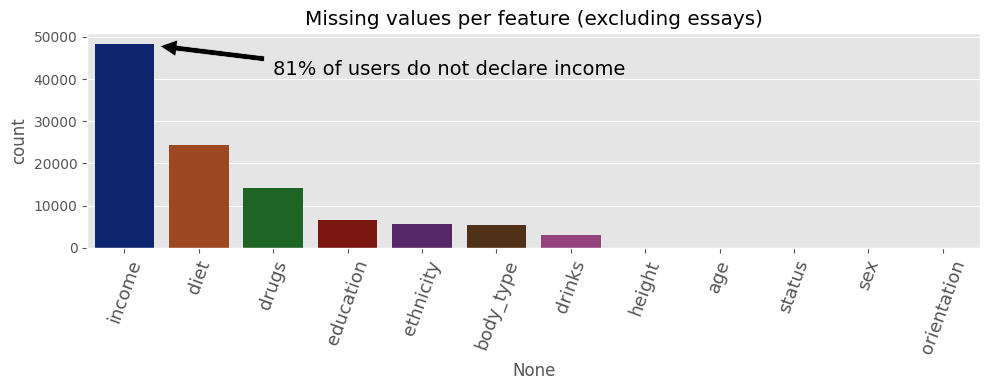

In [14]:
plt.style.use('ggplot')
fig0, ax0 = plt.subplots(figsize=(10,4))
sns.barplot(x=missing_values.index, y = missing_values, palette = 'dark')
ax0.set(xticks=range(len(missing_values)), title='Missing values per feature (excluding essays)',
       ylabel = 'count')
ax0.set_xticklabels(labels=missing_values.index,
                    rotation=70, fontsize=13)
ax0.annotate('81% of users do not declare income ', xy = (0.4, 48000),
            xytext=(2,41000), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05));
fig0.tight_layout()

In [15]:
df.isnull().sum().sort_values(ascending=False)

,0
income,48443
offspring,35562
diet,24396
religion,20227
pets,19922
essay8,19226
drugs,14081
essay6,13772
essay9,12604
essay7,12452


We can see in the picture above that income and offspring have several missing values.

* **Body type** - To convert to ordered categorical
* **Drinks** - To convert to ordered categorical
* **Drugs** - To convert to ordered categorical
* **Education** - To convert to ordered categorical
* **Offspring** - To convert to ordered categorical
* **Smokes** - To convert to ordered categorical
* **Pets** - OHE for "dogs" and "cats" category

We are going to fill missing values in categorical columns with corresponding median value.



<Axes: xlabel='orientation', ylabel='count'>

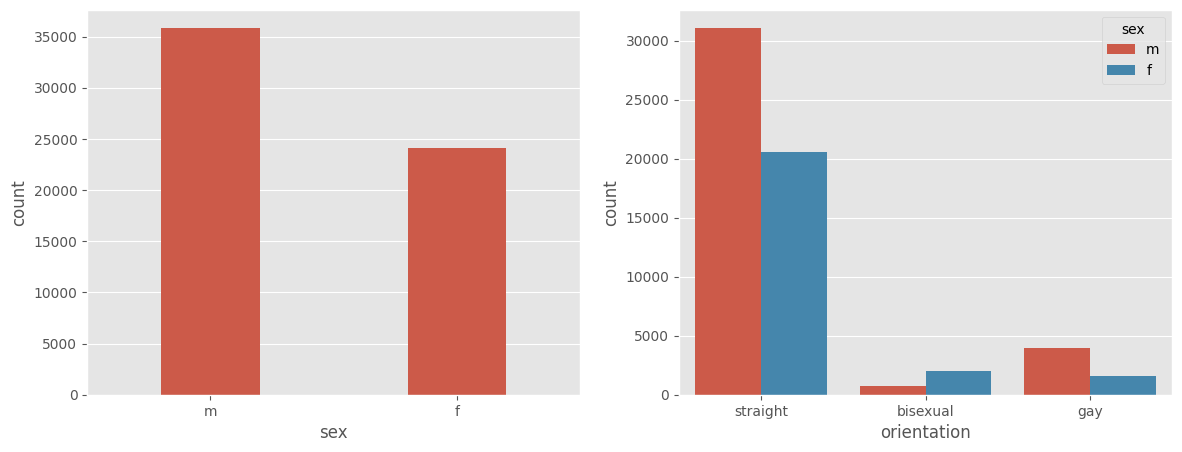

In [16]:
# Sex distribution, Orientation

fig1, ax1 = plt.subplots(ncols=2, figsize=(14,5))
cat_cols = ['sex', 'orientation']
titles = ['Sex distribution', 'Sexual orientation']

sns.countplot(data=df, x='sex', ax=ax1[0], width=0.4)
sns.countplot(data=df, x='orientation', hue='sex', ax=ax1[1])

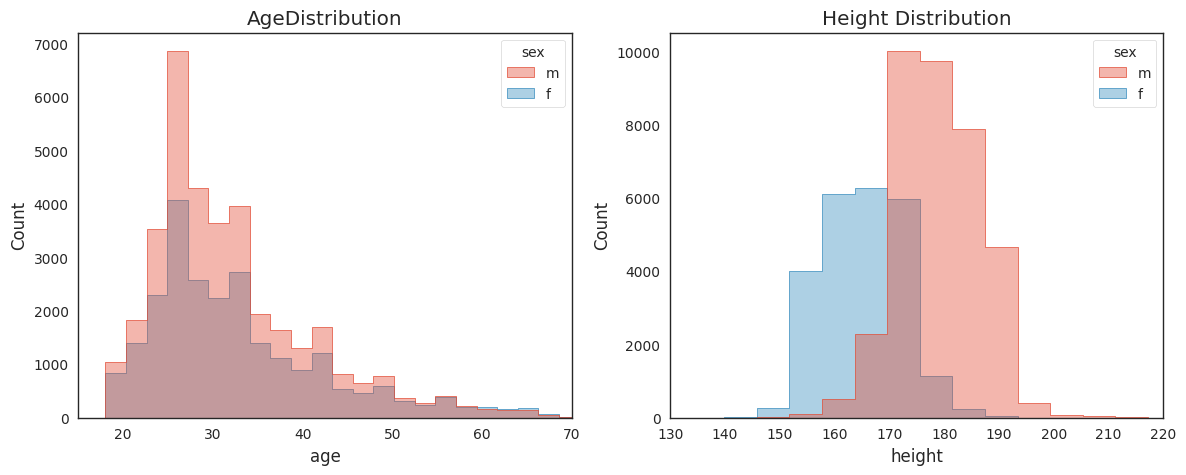

In [17]:
# Age, Height
df['age'] = df['age'].fillna(df['age'].mean())
df['height'] = df['height'].fillna(df['height'].mean())

sns.set_style("white")
num_cols = ['age', 'height']
xlims = [(15, 70), (130, 220)]
titles = ['AgeDistribution', 'Height Distribution']
fig2, ax2 = plt.subplots(ncols=2, figsize=(14,5), sharey=False)
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=ax2[i], hue='sex', element='step',
                bins=40, alpha=0.4)
    ax2[i].set(xlim=xlims[i], title=titles[i])

In [18]:
# Location
df[['city_', 'state_']] = df.location.str.split(pat=', ',
                                                expand=True).loc[:,0:1]
df.loc[:, ['location', 'city_', 'state_']]
df.state_.value_counts(normalize=True).round(4)[:5]*100

,proportion
state_,
california,99.85
new york,0.03
illinois,0.01
massachusetts,0.01
texas,0.01


In [19]:
city_count = df.city_.value_counts(normalize=True).round(3)[:20]*100

<ipython-input-20-0ba04d274513>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_count.index, y=city_count, palette='dark', ax=ax3)


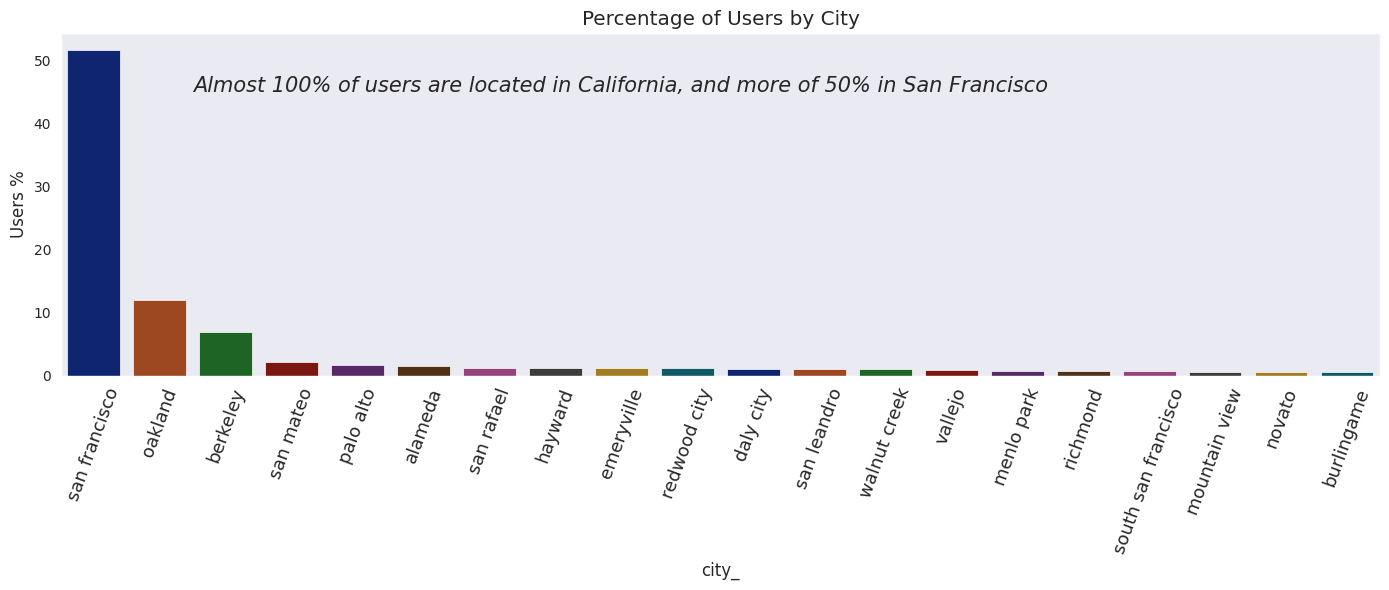

In [20]:
sns.set_style("dark")
fig3, ax3 = plt.subplots(figsize=(14,6))
sns.barplot(x=city_count.index, y=city_count, palette='dark', ax=ax3)
ax3.set(xticks=range(len(city_count)), title='Percentage of Users by City',
       ylabel = 'Users %')
ax3.set_xticklabels(labels=city_count.index, rotation=70,
                   fontsize=13)
ax3.text(1.5, 45, 'Almost 100% of users are located in California, and more of 50% in San Francisco',
        style='italic', fontsize=15)
fig3.tight_layout()

Almost 100% of users are located in California, and more of 50% in San Francisco


## Mapping categories

As there are columns that have several unique values, with teh function below we can map strings into a selected group of few categories, using an ad-hoc dictionary for each features.

I will use an underscore at the end of each handcrafted feature.

In [21]:
def map_cat(a_string, a_dic):
    """
    a_string: a string we want to map with a_dic
    a_dic: a dictionary whose keys are tuples
    """
    for k in a_dic:
        if a_string in k:
            return a_dic.get(k)
    return np.NaN

In [22]:
# Body Type
df.body_type.value_counts(dropna=False)

,count
body_type,
average,14652
fit,12711
athletic,11819
NaN,5297
thin,4711
curvy,3924
a little extra,2629
skinny,1777
full figured,1009


Too many body types in my opinion. Now we try grouping all these body types in just three categories, as described by medical literature.

In [23]:
body_types_dic = {('skinny', 'used up', 'thin'): 'ectomorph',
                 ('average', 'fit', 'athletic', 'jacked'): 'mesomorph',
                 ('a little extra', 'curvy', 'full figured'): 'endomorph'}

body_categories = CategoricalDtype(categories=['ectomorph', 'mesomorph',
                                              'endomorph'], ordered=True)

df['body_type_'] = df.body_type.apply(map_cat, args=(body_types_dic,)).astype(body_categories)
df.body_type_ = df.body_type_.fillna(body_categories.categories
                        [int(np.median(df.body_type_.cat.codes))])

In [24]:
education_categories = CategoricalDtype(categories=['High school or less',
                                                   'Some college',
                                                   'College or more',
                                                   'Post graduate degree'],
                                       ordered=True)

In [25]:
education_dic= {('graduated from high school','dropped out of high school',
                 'working on high school','high school'): 'High school or less',

                ('working on two-year college','dropped out of space camp',
                'two-year college', 'graduated from two-year college',
                'dropped out of college/university','dropped out of two-year college',
                 'dropped out of med school', 'dropped out of law school'): 'Some college',

                ('working on college/university', 'working on space camp',
                'graduated from masters program','graduated from college/university',
                'working on masters program','graduated from space camp',
                'college/university','graduated from law school',
                 'working on ph.d program','space camp',
                 'graduated from med school','working on med school',
                'masters program', 'dropped out of ph.d program',
                'law school','dropped out of masters program',
                'working on law school', 'med school') : 'College or more',

                ('graduated from ph.d program','ph.d program'): 'Post graduate degree'}

In [26]:
df['education_'] = df.education.apply(map_cat, args=(education_dic,)).astype(education_categories)

Let's assign the median value of the category to the missing values of this feature.

In [27]:
df.education_ = df.education_.fillna(education_categories.\
                                    categories[int(np.median(df['education_'].cat.codes))]).astype(education_categories)

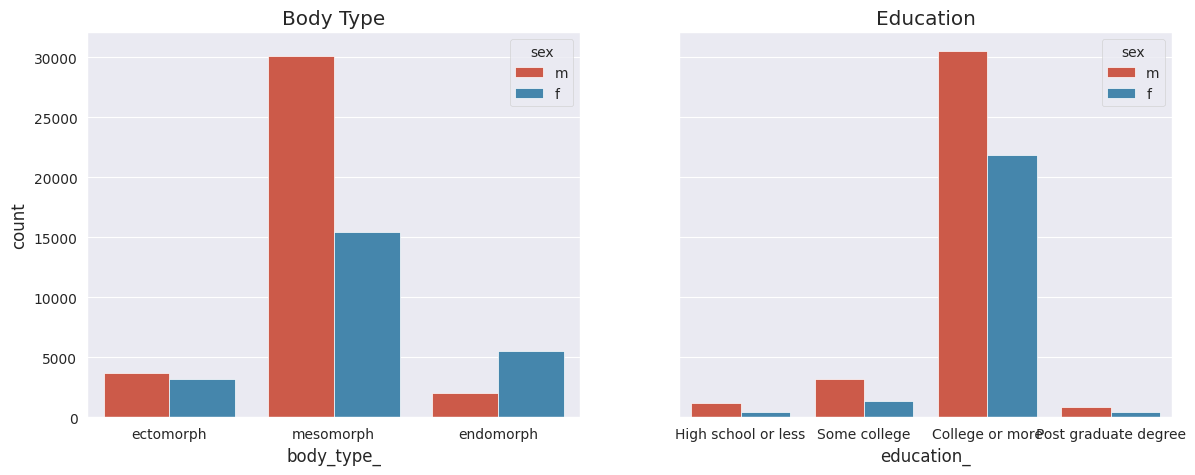

In [28]:
sns.set_style("darkgrid")
cat_cols = ['body_type_', 'education_']
titles = ['Body Type', 'Education']
fig4,ax4 = plt.subplots(ncols=2, figsize=(14,5), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=ax4[i], hue='sex')
    ax4[i].set(title = titles[i])

In [29]:
# Drinks
drinks_categories = CategoricalDtype(categories=['not at all', 'rarely',
                                                'socially',
                                                'often', 'very often',
                                                'desperately'],
                                    ordered=True)
df['drinks_'] = df.drinks.astype(drinks_categories)
df.drinks_ = df.drinks_.fillna(drinks_categories.categories[int(np.median(df.drinks_.cat.codes))])

In [30]:
# Drugs
df.drugs.value_counts(dropna=False)

,count
drugs,
never,37724
NaN,14081
sometimes,7732
often,410


In this case, 82% of the users declare that they never use drugs. Let's assume that we can fill the missing values with 'never'.

In [31]:
df['drugs_'] = df.drugs.fillna('never')
df.drugs_ = pd.Categorical(df.drugs_, categories=['never', 'sometimes',
                                                 'often'],
                          ordered=True)

In [32]:
df.smokes.value_counts(dropna=False)

,count
smokes,
no,43896
NaN,5513
sometimes,3787
when drinking,3040
yes,2231
trying to quit,1480


In [33]:
43896 / len(df)

0.7322468180225866

As 73% of individuals don't smoke. So we will fill the missing values with 'no'.

In [34]:
smokes_dic = {('no',): 'no',
             ('sometimes', 'when drinking', 'trying to quit'): 'sometimes',
             ('yes',):'yes'}
smokes_categories = CategoricalDtype(categories=['no', 'sometimes',
                                                'yes'], ordered=True)
df['smokes_'] = df.smokes.apply(map_cat, args=(smokes_dic,)).astype(smokes_categories)
df.smokes_ = df.smokes_.fillna('no').astype(smokes_categories)
df.smokes_.value_counts(dropna=False).sort_index()

,count
smokes_,
no,49409
sometimes,8307
yes,2231


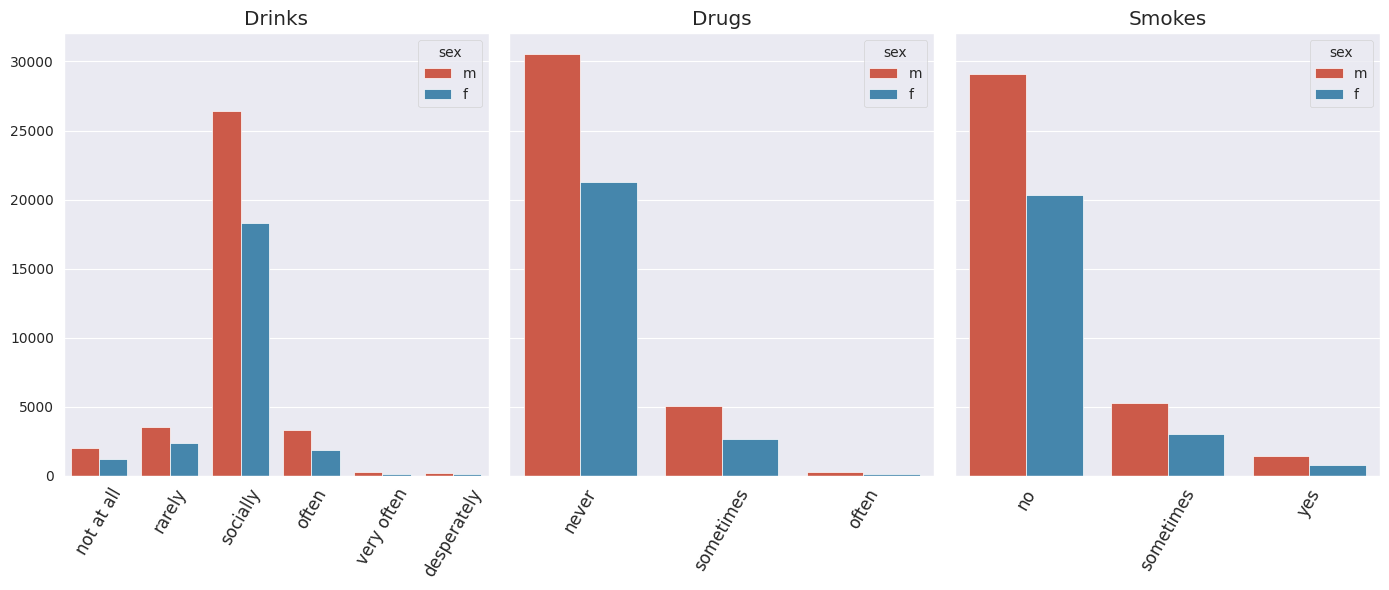

In [35]:
sns.set_style("darkgrid")
cat_cols = ['drinks_', 'drugs_', 'smokes_']
titles = ['Drinks', 'Drugs', 'Smokes']
xlabels = [list(drinks_categories.categories), ['never', 'sometimes',
            'often'], list(smokes_categories.categories)]
ticks = [6, 3, 3]
fig5, ax5 = plt.subplots(ncols=3, figsize=(14,6), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x = col, ax=ax5[i], hue='sex')
    ax5[i].set(title=titles[i], xticks = range(len(xlabels[i])),
               xlabel='', ylabel='')
    ax5[i].set_xticklabels(labels=xlabels[i], rotation=60, fontsize=12)
fig5.tight_layout()

In [36]:
# Pets
df.pets.value_counts(dropna=False)

,count
pets,
NaN,19922
likes dogs and likes cats,14814
likes dogs,7224
likes dogs and has cats,4313
has dogs,4134
has dogs and likes cats,2333
likes dogs and dislikes cats,2029
has dogs and has cats,1474
has cats,1406


It makes sense to create two new columns: likes_dogs, likes_cats. we assign 1 if the user has or likes the corresponding kind of pet, and 0 if he does not. Let's assign a 0 in case of missing values (np.NaN), in order to be in the safe zone in regards of this feature.

In [37]:
df.pets = df.pets.fillna('No')

In [38]:
def likes_pet(s, species):
    dogs_regex = re.compile(r'((?<!dis)likes |has )dogs')
    cats_regex = re.compile(r'((?<!dis)likes |has )cats')
    if species == 'dog':
        return 'Yes' if bool(dogs_regex.search(s)) else 'No'
    elif species == 'cat':
        return 'Yes' if bool(cats_regex.search(s)) else 'No'
    else:
        return 'No'

In [39]:
df['likes_dogs_'] = df.pets.apply(likes_pet, args=('dog',))
df['likes_cats_'] = df.pets.apply(likes_pet, args = ('cat',))
df['likes_dogs_'] = pd.Categorical(df.likes_dogs_, categories=['No',
                                                        'Yes'], ordered=True)
df['likes_cats_'] = pd.Categorical(df.likes_cats_,categories=['No',
                                                             'Yes'], ordered=True)

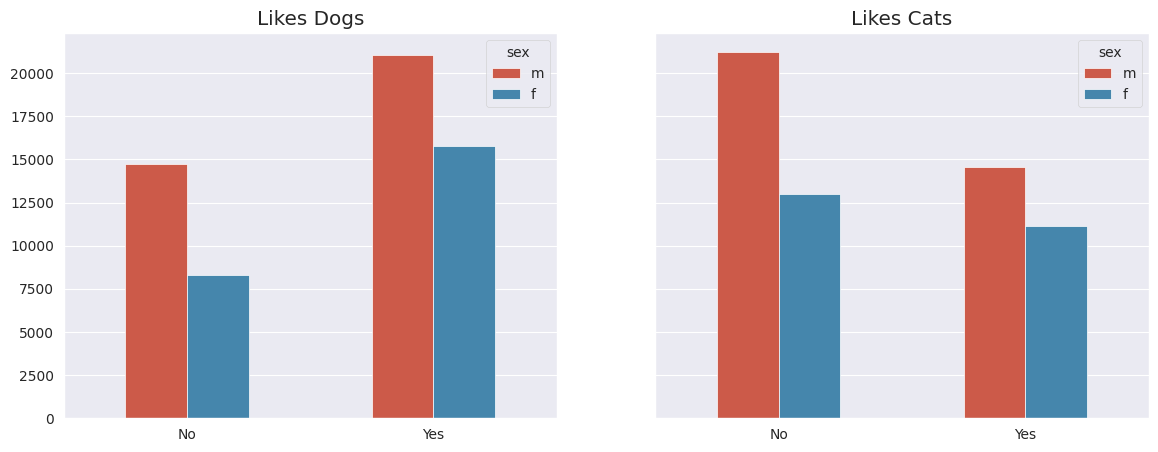

In [40]:
sns.set_style("darkgrid")
cat_cols = ['likes_dogs_', 'likes_cats_']
titles = ['Likes Dogs', 'Likes Cats']
fig6, ax6 = plt.subplots(ncols=2, figsize=(14,5), sharey=True)
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x= col, ax=ax6[i], hue='sex', width=0.5)
    ax6[i].set(title = titles[i], xlabel='', ylabel='')

**Clustering Users. Unsupervised Learning**

Now we have the features of interest as numerical values. And we can use a clustering algorithm in order to form groups of users with affinity. In this case we are going to apply k-means clustering with scikit-learn. Also apply dbscan and GMM.

In [41]:
features = ['age', 'height', 'body_type_', 'education_', 'drinks_',
           'drugs_', 'smokes_', 'likes_dogs_', 'likes_cats_']

In [42]:
X = df[features[0:2]].copy()
X.head()

,age,height
0.0,22.0,190.0
1.0,35.0,178.0
2.0,38.0,173.0
3.0,23.0,180.0
4.0,29.0,168.0


Now we transform the categorical data into numerical data, using teh attribute cat.codes of the categorical features.

In [43]:
for feat in features[2:]:
    X[feat] = df[feat].cat.codes


X.isnull().sum()

,0
age,0
height,0
body_type_,0
education_,0
drinks_,0
drugs_,0
smokes_,0
likes_dogs_,0
likes_cats_,0


In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform='pandas')

X_scaled = scaler.fit_transform(X)

**Inertia**

As per sklearn documentation, inertia is the sum of squared distances of samples to their closest cluster centre.

In [45]:
num_clusters = list(np.arange(1, 21))

inertias = []

for k in num_clusters:
    model = KMeans(n_clusters = k, n_init='auto')
    model.fit(X_scaled)
    inertias.append(model.inertia_)

No we plot the inertias list in order to find the optimal number of clusters. we are using the elbow method: when inertia begins to decrease more slowly.

[[<matplotlib.axis.XTick at 0x7ababdd27dc0>,
 Text(0.5, 0, 'clusters'),
 Text(0.5, 1.0, 'Inertia')]

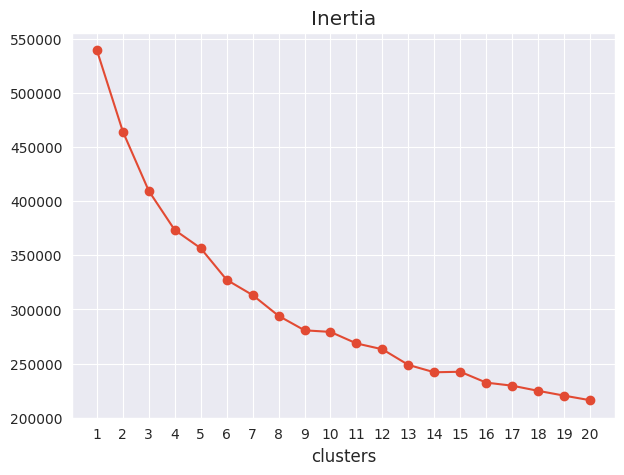

In [46]:
fig7, ax7 = plt.subplots(figsize = (7,5))

ax7.plot(num_clusters, inertias, '-o')
ax7.set(xticks=num_clusters, xlabel='clusters', title='Inertia')

The choice of the numebr of clusters is always a trade-off to minimise inertia and to keep the numebr of clusters as low as possible. In this case, it makes sense to choose 12 as the number of clusters.

The sklearn algorithm assigns to each point (user) a label, found with the attribute labels_, that we assign to anew columns 'membership' in our dataframe.

In [47]:
k = 12
model = KMeans(n_clusters = k, n_init = 'auto')
model.fit(X_scaled)
df['membership'] = model.labels_
df.membership.value_counts()

,count
membership,
6,12882
8,8036
7,7455
1,5455
9,4574
3,4185
10,3616
2,3469
4,3215


[Text(0.5, 1.0, 'Users per cluster'), Text(0, 0.5, '')]

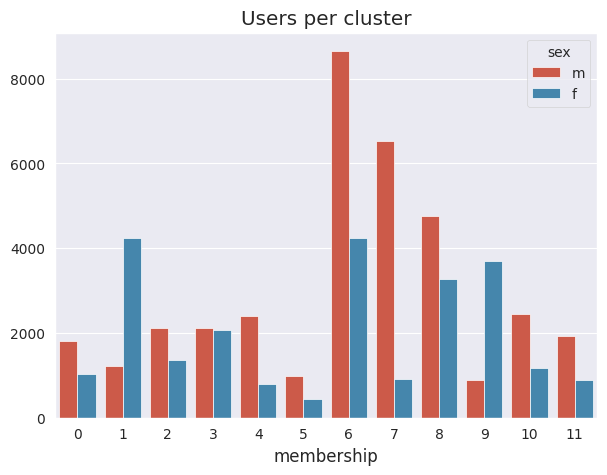

In [48]:
fig8, ax8 = plt.subplots(figsize=(7,5))

sns.countplot(data=df, x='membership', ax=ax8, hue='sex')
ax8.set(title = 'Users per cluster', ylabel='')

In [49]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 5
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_model.fit(X_scaled)

df['membership'] = dbscan_model.labels_
df.membership.value_counts()


,count
membership,
9,9525
3,8200
-1,7483
11,6454
28,1387
32,1210
10,1156
8,1042
24,1033


In [50]:
from sklearn.mixture import GaussianMixture

num_clusters = list(np.arange(1, 21))
bics = []

for k in num_clusters:
    gmm_model = GaussianMixture(n_components=k, random_state=42)
    gmm_model.fit(X_scaled)
    bics.append(gmm_model.bic(X_scaled))

optimal_k = num_clusters[np.argmin(bics)]


In [61]:
optimal_k

20

**Lover recommendation: An example**

Features of interest we are considering:

In [51]:
features = ['age', 'height', 'sex', 'orientation', 'body_type_',
           'education_', 'drinks_', 'drugs_', 'smokes_',
           'likes_dogs_', 'likes_cats_', 'membership']

In [52]:
df.membership.value_counts()

,count
membership,
9,9525
3,8200
-1,7483
11,6454
28,1387
32,1210
10,1156
8,1042
24,1033


Let's say that we want to recommend profiles that user_id 42 can be interested in. This user is a male, with sexual orientation 'straight'.

In [53]:
df.loc[42:42, features]

,age,height,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
42.0,30.0,190.0,m,straight,mesomorph,College or more,often,sometimes,no,No,No,19


In [54]:
users = df.loc[(df.sex == 'f')&
              (df.membership == df.at[42, 'membership']) &
              (df.orientation == 'straight')].index
print(f'So we have found {len(users)} female users in the same cluster.\n')

So we have found 35 female users in the same cluster.



**Distances**

Now we can prepare an ordered list based on affinity. First of all we need to calculate the distance between user 42 and the rest of profiles we have just found.

In [55]:
def distance(row, user):
    result = 0
    for i, v in enumerate(row):
        result += (v - user[i])**2
    return result ** 0.5;

In [56]:
user = X_scaled.loc[42]
distances = X_scaled.loc[users].apply(distance, axis=1,
                            args=(user,)).sort_values();

<ipython-input-55-0d1d4238236f>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result += (v - user[i])**2


In [57]:
df.loc[42:42, features]

,age,height,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
42.0,30.0,190.0,m,straight,mesomorph,College or more,often,sometimes,no,No,No,19


In [58]:
df.loc[distances.index, features].head(10)

,age,height,sex,orientation,body_type_,education_,drinks_,drugs_,smokes_,likes_dogs_,likes_cats_,membership
31343.0,25.0,183.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
55767.0,30.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
13776.0,32.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
42326.0,25.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
16932.0,25.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
33695.0,33.0,173.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
5879.0,34.0,173.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
40510.0,25.0,173.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
27386.0,21.0,175.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19
57489.0,44.0,178.0,f,straight,mesomorph,College or more,often,sometimes,no,No,No,19


We can see that the features are pretty similar.

**Affinity**

In [59]:
gamma = 1 / (len(features))

And now we can print the top ten choices for the user 42 with a similarity score:

In [60]:
S = pd.DataFrame(distances.apply(lambda x: round(np.exp(-x * gamma)*100, 1)).rename('affinity'))
S.rename_axis('user_id', inplace=True)
print('Top ten users by affinity with user_id = 42')
S.head(10)

Top ten users by affinity with user_id = 42


,affinity
user_id,
31343.0,93.0
55767.0,88.4
13776.0,88.3
42326.0,87.7
16932.0,87.7
33695.0,86.7
5879.0,86.5
40510.0,86.3
27386.0,86.3
